# Frequency Vector Weirdness

Here I document some extremely undesirable behavior with the spectral analysis of uneven timeseries, which affects both Lomb-Scargle and WWZ. 

## Benthic Stack

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ky BP]', ylabel='resolution [ky BP]'>)

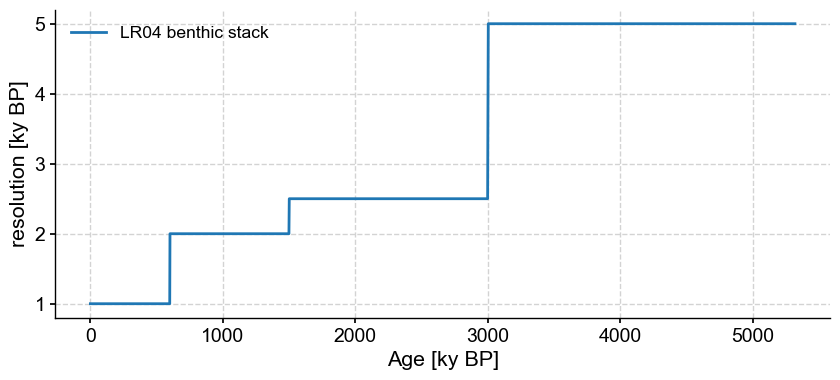

In [2]:
import pyleoclim as pyleo
LR04 = pyleo.utils.load_dataset('LR04')
LR04_res = LR04.resolution()
LR04_res.plot()

## Adventures with the Lomb-Scargle Periodogram
let us first do a naïve spectral analysis of this record:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [ky]', ylabel='PSD'>)

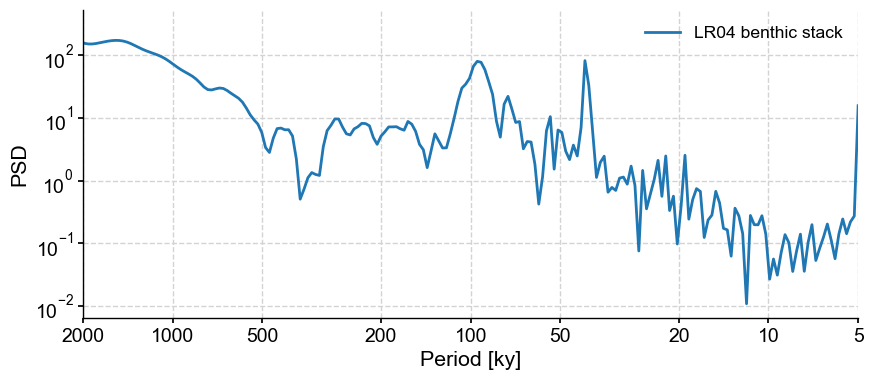

In [3]:
LR04.standardize().spectral().plot()

We notice familiar periodicities at 40 and 100 ky as well as some power and very low frequencies due to the secular trend. However, there is a very unexpected peek at 5 ky. Is it a consequence of the change in resolution? Even limiting to the Pleistocene shows the same issue:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [ky]', ylabel='PSD'>)

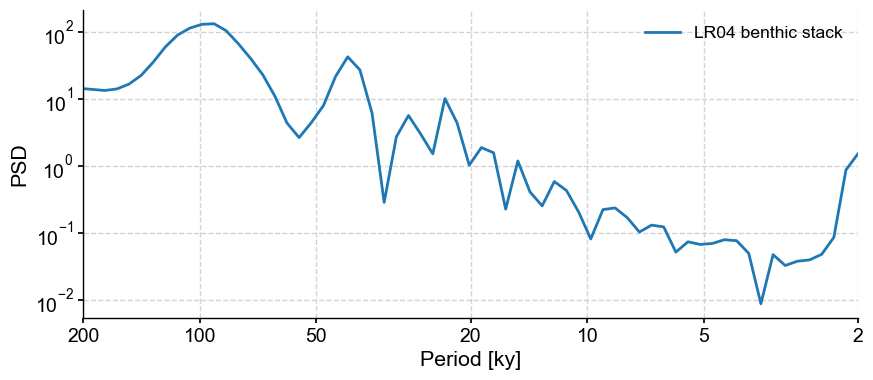

In [5]:
LR04pl = LR04.slice([0,900]).standardize() # select the Pleistocene for faster computations
LR04pl.spectral().plot()

We need to take out the big guns here: let's make a custom frequency vector and pass it to the method. 

In [6]:
freq_custom = pyleo.utils.wavelet.freq_vector_lomb_scargle(LR04pl.time, ofac=4, hifac=0.5)

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [ky]', ylabel='PSD'>)

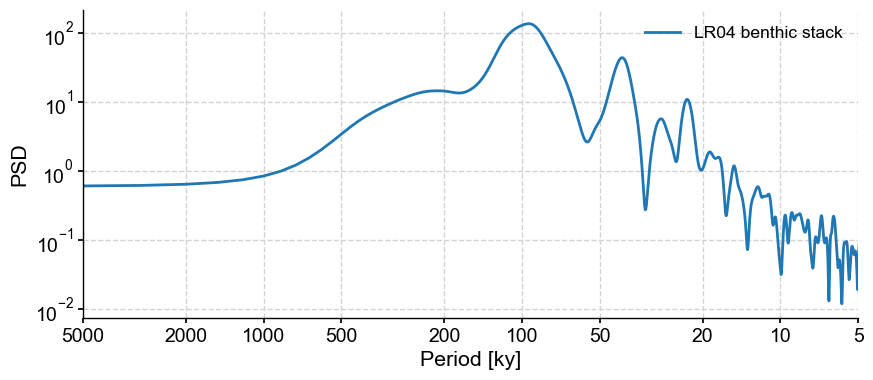

In [8]:
psd_ls = LR04pl.spectral(settings={'freq':freq_custom})
psd_ls.plot() 

So that problem went away, but here's another: Lomb-Scargle sucks! It can't properly represent the spectrum of an AR(1), creating a bump where there shouldn't be:

Performing spectral analysis on individual series: 100%|██████████| 100/100 [00:02<00:00, 34.62it/s]


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [ky]', ylabel='PSD'>)

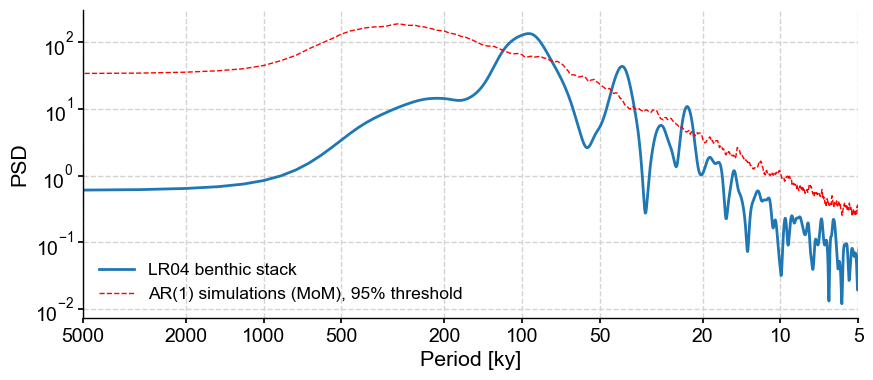

In [10]:
psd_ls_uar1 = psd_ls.signif_test(method='ar1sim',number=100) 
psd_ls_uar1.plot()

Do we get better luck with WWZ? 

### Fun with WWZ

Let's start with the full record.

In [12]:
psd_wwz = LR04.standardize().spectral(method='wwz')

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [ky]', ylabel='PSD'>)

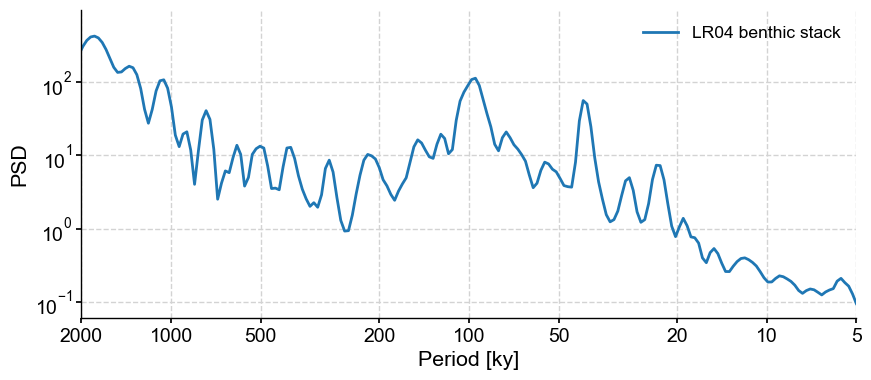

In [13]:
psd_wwz.plot()

That's a lot better, but still a suspicious bump at high-frequencies. Let's see if it vanishes with an anti alias filter:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [ky]', ylabel='PSD'>)

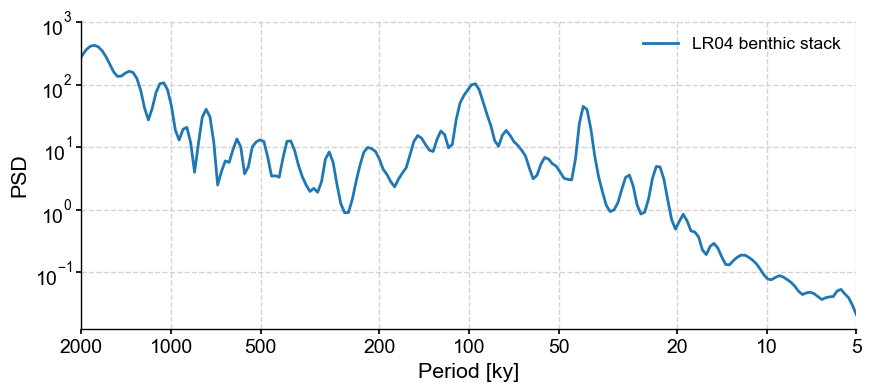

In [14]:
psd_wwz.anti_alias().plot()

Nope. OK, I could live with that, but here's the kicker: the weird peak appears over the Pleistocene!

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [ky]', ylabel='PSD'>)

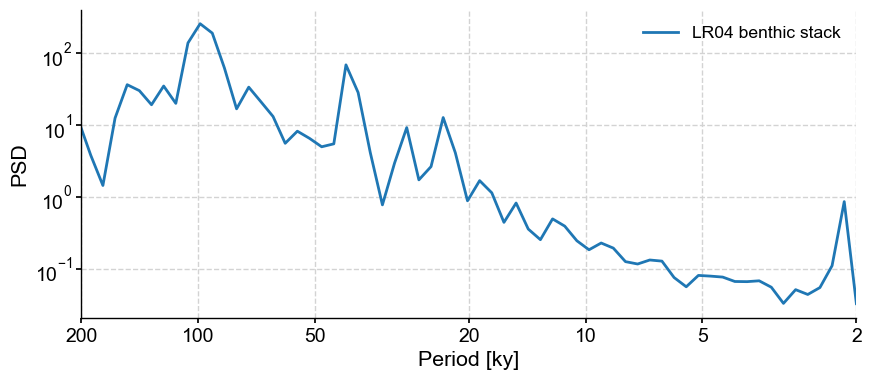

In [15]:
LR04pl.standardize().spectral(method='wwz').plot()

Awkward!!! Does it go away with a custom frequency vector?

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [ky]', ylabel='PSD'>)

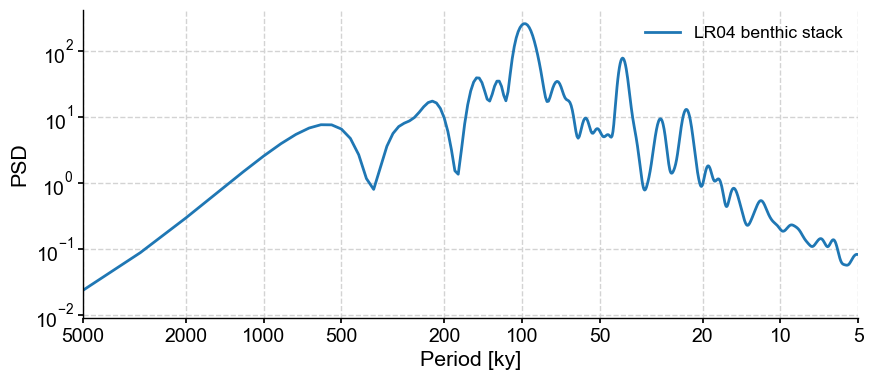

In [16]:
psd_wwz = LR04pl.spectral(method='wwz', settings={'freq':freq_custom})
psd_wwz.plot()

Ah. So that low-frequency cut is an artifact of the freq vector. Unfortunately , none of the canned methods to produce it give very convincing results. 

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [ky]', ylabel='PSD'>)

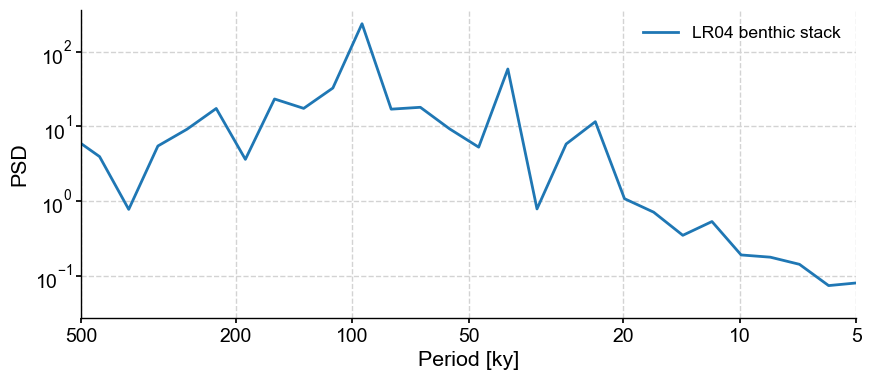

In [20]:
LR04pl.spectral(method='wwz', freq_method='scale').plot()

## MWE for debugging

Performing spectral analysis on individual series: 100%|██████████| 100/100 [00:01<00:00, 90.65it/s]


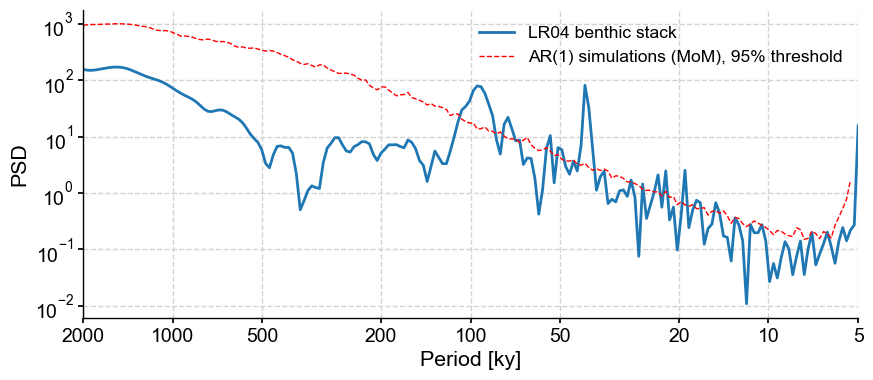

In [2]:
import pyleoclim as pyleo
LR04 = pyleo.utils.load_dataset('LR04')
psd_ls = LR04.standardize().spectral()
psd_sig = psd_ls.signif_test(number=100)
fig, ax = psd_sig.plot()
fig.savefig('./freaqy_spectrum.png',dpi=300)